# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenated, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, 32, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 64, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 128, 2)
    #encoder_layer4 = encoder_block(encoder_layer3, 256, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encoder_layer3, 256, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #decoder_layer4 = decoder_block(conv_layer, encoder_layer3, 256)
    decoder_layer3 = decoder_block(conv_layer, encoder_layer2, 128)
    decoder_layer2 = decoder_block(decoder_layer3, encoder_layer1, 64)
    decoder_layer1 = decoder_block(decoder_layer2, inputs, 32)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer1)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0001
batch_size = 100
num_epochs = 85
steps_per_epoch = 83
validation_steps = 24
workers = 2

Epoch 1/85
82/83 [============================>.] - ETA: 1s - loss: 1.1754

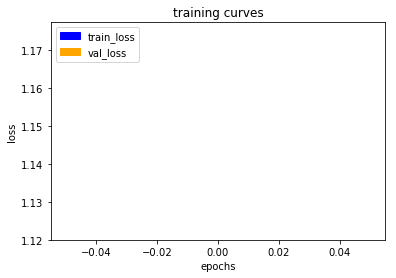

83/83 [==============================] - 113s - loss: 1.1742 - val_loss: 1.1227
Epoch 2/85
82/83 [============================>.] - ETA: 1s - loss: 1.0446

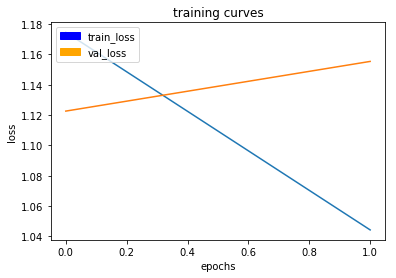

83/83 [==============================] - 109s - loss: 1.0442 - val_loss: 1.1554
Epoch 3/85
82/83 [============================>.] - ETA: 1s - loss: 0.9858

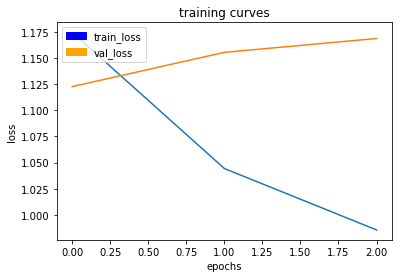

83/83 [==============================] - 109s - loss: 0.9855 - val_loss: 1.1686
Epoch 4/85
82/83 [============================>.] - ETA: 1s - loss: 0.9263

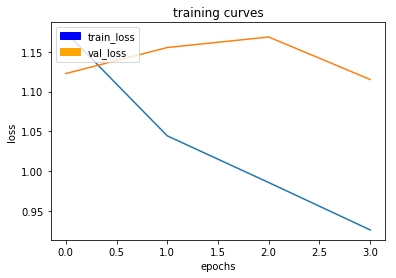

83/83 [==============================] - 109s - loss: 0.9259 - val_loss: 1.1152
Epoch 5/85
82/83 [============================>.] - ETA: 1s - loss: 0.8592

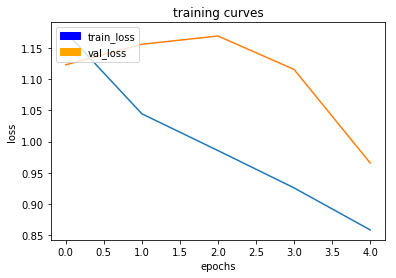

83/83 [==============================] - 110s - loss: 0.8587 - val_loss: 0.9659
Epoch 6/85
82/83 [============================>.] - ETA: 1s - loss: 0.7796

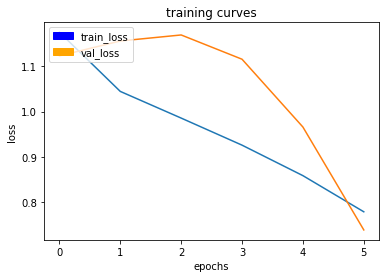

83/83 [==============================] - 110s - loss: 0.7791 - val_loss: 0.7394
Epoch 7/85
82/83 [============================>.] - ETA: 1s - loss: 0.6940

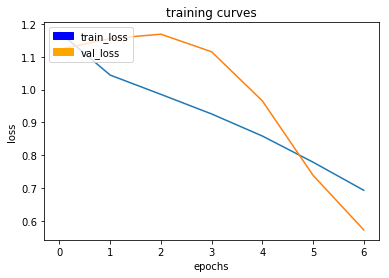

83/83 [==============================] - 109s - loss: 0.6935 - val_loss: 0.5731
Epoch 8/85
82/83 [============================>.] - ETA: 1s - loss: 0.6173

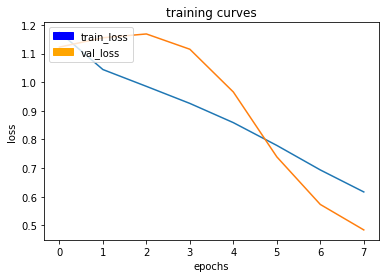

83/83 [==============================] - 109s - loss: 0.6167 - val_loss: 0.4841
Epoch 9/85
82/83 [============================>.] - ETA: 1s - loss: 0.5463

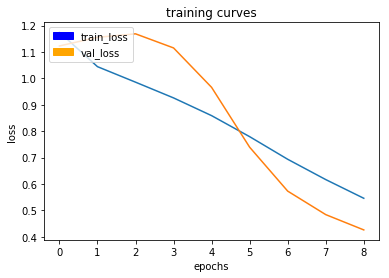

83/83 [==============================] - 109s - loss: 0.5458 - val_loss: 0.4262
Epoch 10/85
82/83 [============================>.] - ETA: 1s - loss: 0.4817

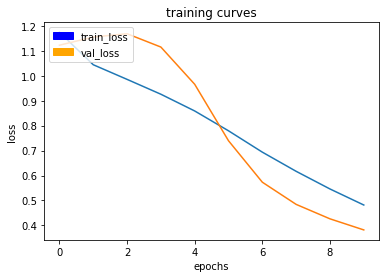

83/83 [==============================] - 109s - loss: 0.4815 - val_loss: 0.3817
Epoch 11/85
82/83 [============================>.] - ETA: 1s - loss: 0.4239

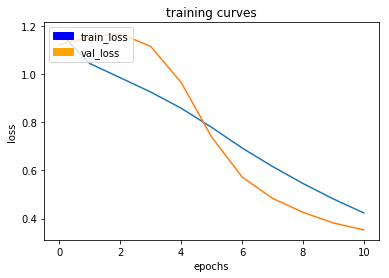

83/83 [==============================] - 110s - loss: 0.4235 - val_loss: 0.3529
Epoch 12/85
82/83 [============================>.] - ETA: 1s - loss: 0.3725

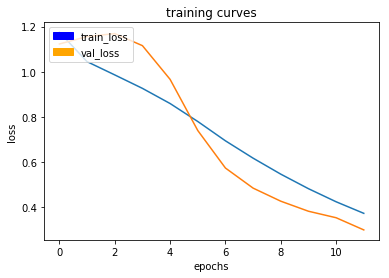

83/83 [==============================] - 108s - loss: 0.3723 - val_loss: 0.2990
Epoch 13/85
82/83 [============================>.] - ETA: 1s - loss: 0.3279

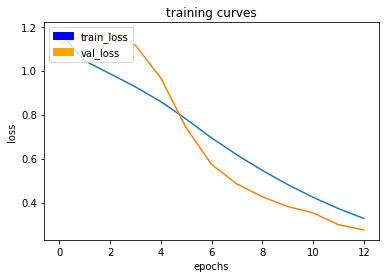

83/83 [==============================] - 110s - loss: 0.3275 - val_loss: 0.2753
Epoch 14/85
82/83 [============================>.] - ETA: 1s - loss: 0.2888

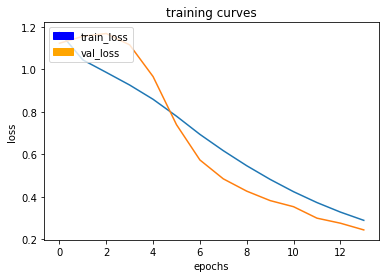

83/83 [==============================] - 110s - loss: 0.2886 - val_loss: 0.2436
Epoch 15/85
82/83 [============================>.] - ETA: 1s - loss: 0.2555

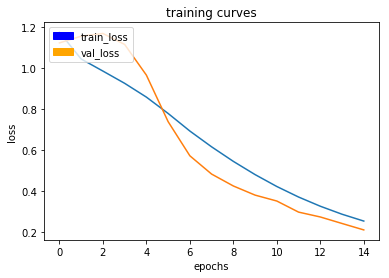

83/83 [==============================] - 110s - loss: 0.2553 - val_loss: 0.2123
Epoch 16/85
82/83 [============================>.] - ETA: 1s - loss: 0.2270

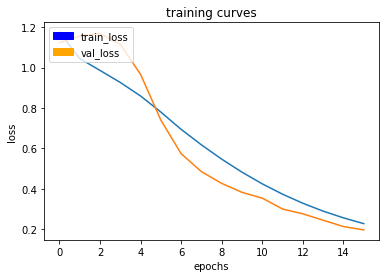

83/83 [==============================] - 110s - loss: 0.2267 - val_loss: 0.1957
Epoch 17/85
82/83 [============================>.] - ETA: 1s - loss: 0.2027

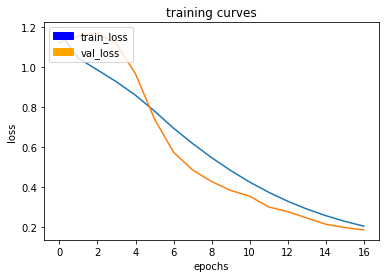

83/83 [==============================] - 109s - loss: 0.2025 - val_loss: 0.1837
Epoch 18/85
82/83 [============================>.] - ETA: 1s - loss: 0.1816

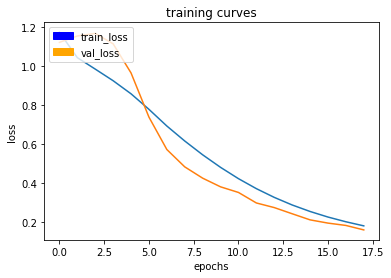

83/83 [==============================] - 109s - loss: 0.1815 - val_loss: 0.1607
Epoch 19/85
82/83 [============================>.] - ETA: 1s - loss: 0.1638

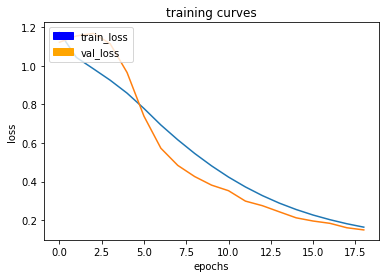

83/83 [==============================] - 109s - loss: 0.1639 - val_loss: 0.1496
Epoch 20/85
82/83 [============================>.] - ETA: 1s - loss: 0.1486

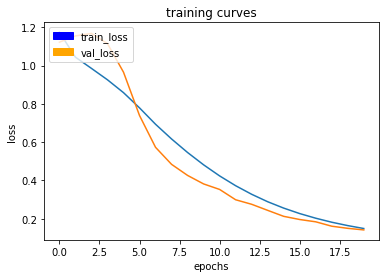

83/83 [==============================] - 109s - loss: 0.1486 - val_loss: 0.1413
Epoch 21/85
82/83 [============================>.] - ETA: 1s - loss: 0.1359

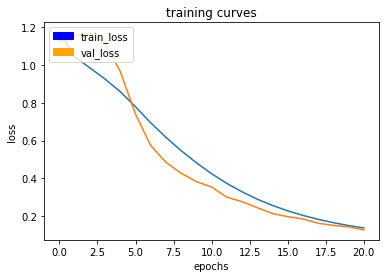

83/83 [==============================] - 110s - loss: 0.1358 - val_loss: 0.1254
Epoch 22/85
82/83 [============================>.] - ETA: 1s - loss: 0.1245

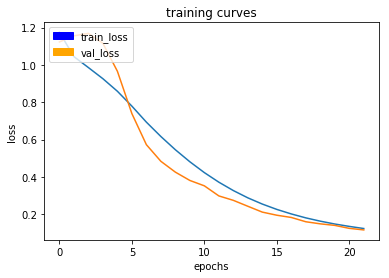

83/83 [==============================] - 109s - loss: 0.1245 - val_loss: 0.1171
Epoch 23/85
82/83 [============================>.] - ETA: 1s - loss: 0.1146

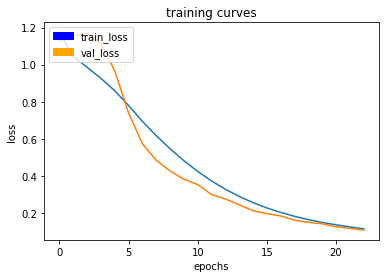

83/83 [==============================] - 109s - loss: 0.1145 - val_loss: 0.1084
Epoch 24/85
82/83 [============================>.] - ETA: 1s - loss: 0.1061

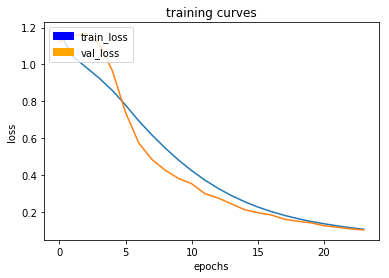

83/83 [==============================] - 109s - loss: 0.1060 - val_loss: 0.1026
Epoch 25/85
82/83 [============================>.] - ETA: 1s - loss: 0.0985

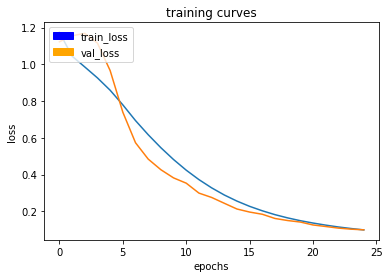

83/83 [==============================] - 109s - loss: 0.0985 - val_loss: 0.0990
Epoch 26/85
82/83 [============================>.] - ETA: 1s - loss: 0.0922

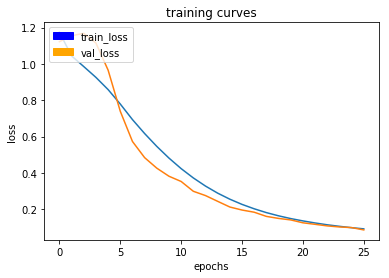

83/83 [==============================] - 108s - loss: 0.0921 - val_loss: 0.0862
Epoch 27/85
82/83 [============================>.] - ETA: 1s - loss: 0.0864

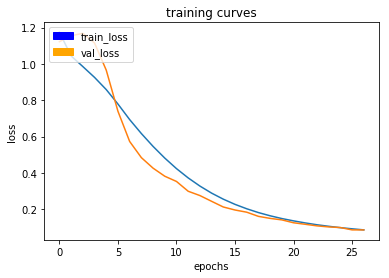

83/83 [==============================] - 109s - loss: 0.0863 - val_loss: 0.0861
Epoch 28/85
82/83 [============================>.] - ETA: 1s - loss: 0.0812

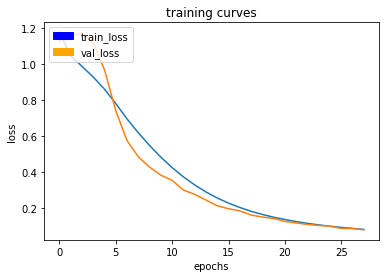

83/83 [==============================] - 109s - loss: 0.0811 - val_loss: 0.0781
Epoch 29/85
82/83 [============================>.] - ETA: 1s - loss: 0.0768

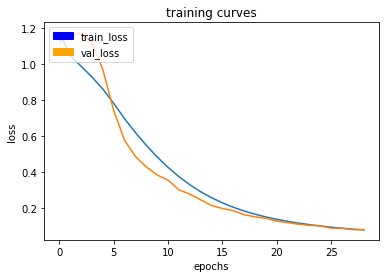

83/83 [==============================] - 109s - loss: 0.0768 - val_loss: 0.0791
Epoch 30/85
82/83 [============================>.] - ETA: 1s - loss: 0.0729

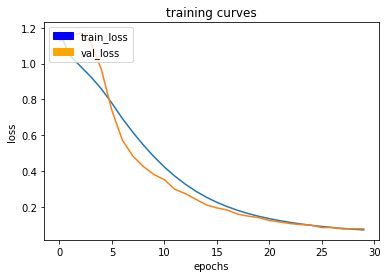

83/83 [==============================] - 110s - loss: 0.0729 - val_loss: 0.0789
Epoch 31/85
82/83 [============================>.] - ETA: 1s - loss: 0.0693

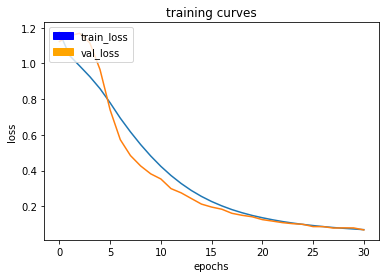

83/83 [==============================] - 109s - loss: 0.0692 - val_loss: 0.0677
Epoch 32/85
82/83 [============================>.] - ETA: 1s - loss: 0.0657

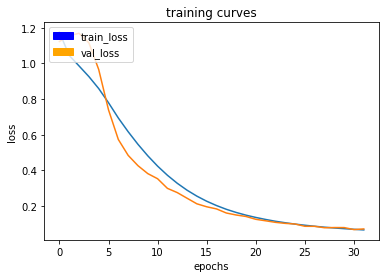

83/83 [==============================] - 109s - loss: 0.0659 - val_loss: 0.0714
Epoch 33/85
82/83 [============================>.] - ETA: 1s - loss: 0.0634

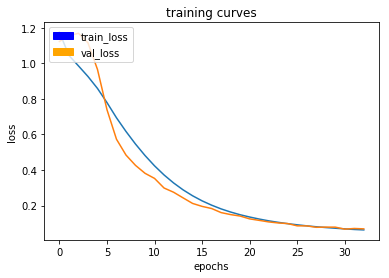

83/83 [==============================] - 109s - loss: 0.0634 - val_loss: 0.0693
Epoch 34/85
82/83 [============================>.] - ETA: 1s - loss: 0.0604

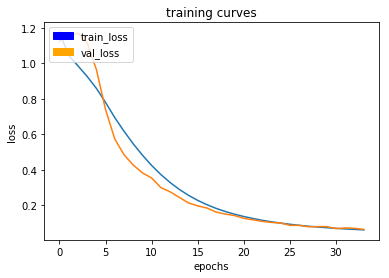

83/83 [==============================] - 110s - loss: 0.0604 - val_loss: 0.0632
Epoch 35/85
82/83 [============================>.] - ETA: 1s - loss: 0.0582

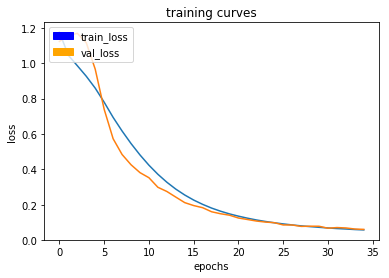

83/83 [==============================] - 110s - loss: 0.0582 - val_loss: 0.0612
Epoch 36/85
82/83 [============================>.] - ETA: 1s - loss: 0.0560

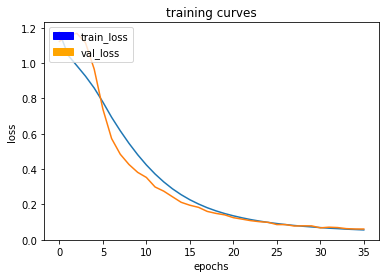

83/83 [==============================] - 109s - loss: 0.0560 - val_loss: 0.0612
Epoch 37/85
82/83 [============================>.] - ETA: 1s - loss: 0.0540

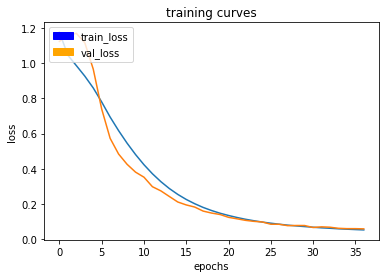

83/83 [==============================] - 109s - loss: 0.0540 - val_loss: 0.0600
Epoch 38/85
82/83 [============================>.] - ETA: 1s - loss: 0.0527

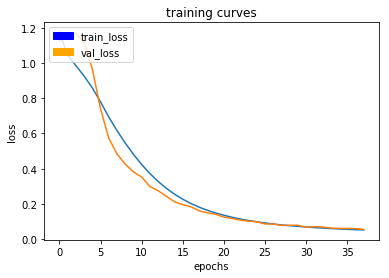

83/83 [==============================] - 109s - loss: 0.0527 - val_loss: 0.0558
Epoch 39/85
82/83 [============================>.] - ETA: 1s - loss: 0.0505

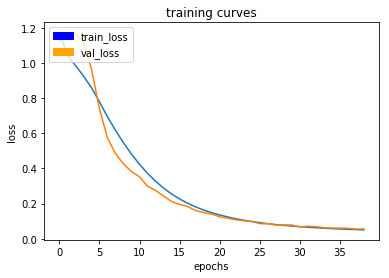

83/83 [==============================] - 110s - loss: 0.0507 - val_loss: 0.0561
Epoch 40/85
82/83 [============================>.] - ETA: 1s - loss: 0.0494

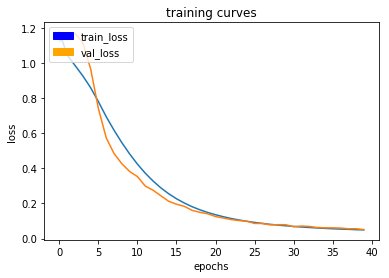

83/83 [==============================] - 109s - loss: 0.0494 - val_loss: 0.0516
Epoch 41/85
82/83 [============================>.] - ETA: 1s - loss: 0.0481

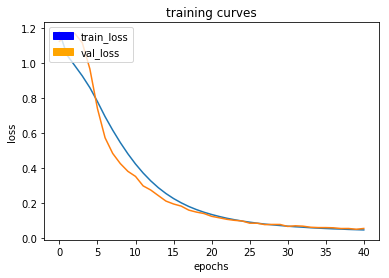

83/83 [==============================] - 110s - loss: 0.0480 - val_loss: 0.0561
Epoch 42/85
82/83 [============================>.] - ETA: 1s - loss: 0.0467

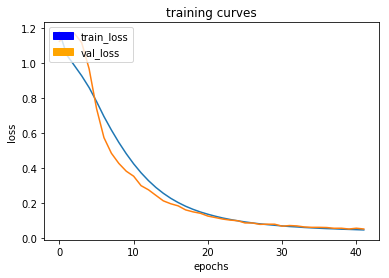

83/83 [==============================] - 109s - loss: 0.0467 - val_loss: 0.0517
Epoch 43/85
82/83 [============================>.] - ETA: 1s - loss: 0.0453

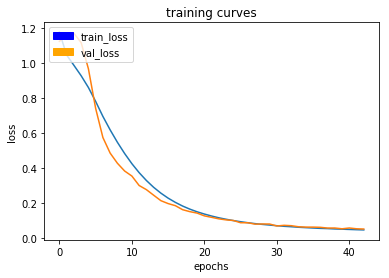

83/83 [==============================] - 109s - loss: 0.0452 - val_loss: 0.0502
Epoch 44/85
82/83 [============================>.] - ETA: 1s - loss: 0.0441

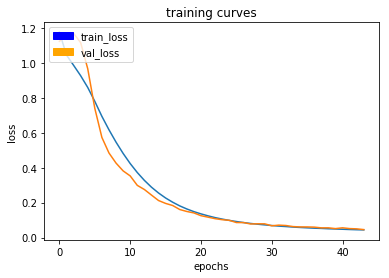

83/83 [==============================] - 110s - loss: 0.0441 - val_loss: 0.0459
Epoch 45/85
82/83 [============================>.] - ETA: 1s - loss: 0.0429

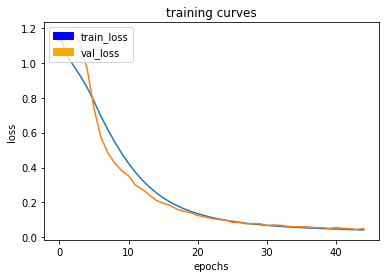

83/83 [==============================] - 110s - loss: 0.0429 - val_loss: 0.0514
Epoch 46/85
82/83 [============================>.] - ETA: 1s - loss: 0.0422

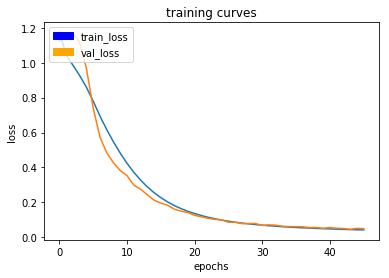

83/83 [==============================] - 110s - loss: 0.0421 - val_loss: 0.0495
Epoch 47/85
82/83 [============================>.] - ETA: 1s - loss: 0.0412

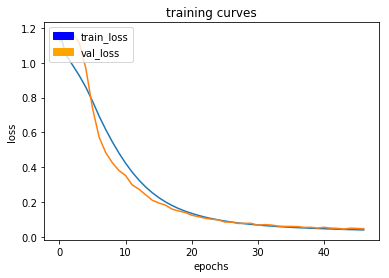

83/83 [==============================] - 109s - loss: 0.0411 - val_loss: 0.0483
Epoch 48/85
82/83 [============================>.] - ETA: 1s - loss: 0.0405

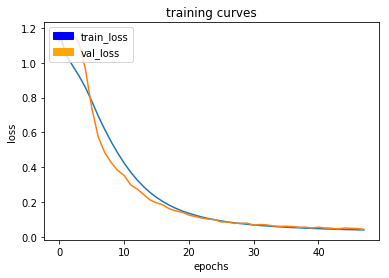

83/83 [==============================] - 109s - loss: 0.0405 - val_loss: 0.0436
Epoch 49/85
82/83 [============================>.] - ETA: 1s - loss: 0.0397

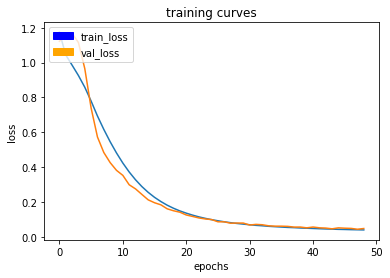

83/83 [==============================] - 109s - loss: 0.0397 - val_loss: 0.0476
Epoch 50/85
82/83 [============================>.] - ETA: 1s - loss: 0.0387

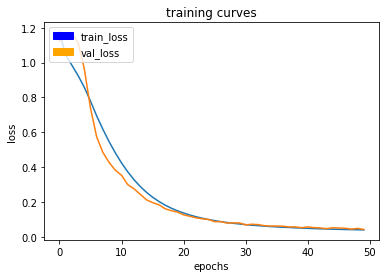

83/83 [==============================] - 109s - loss: 0.0388 - val_loss: 0.0416
Epoch 51/85
82/83 [============================>.] - ETA: 1s - loss: 0.0381

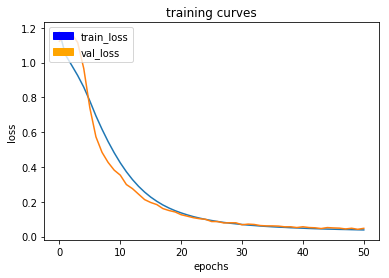

83/83 [==============================] - 110s - loss: 0.0380 - val_loss: 0.0471
Epoch 52/85
82/83 [============================>.] - ETA: 1s - loss: 0.0373

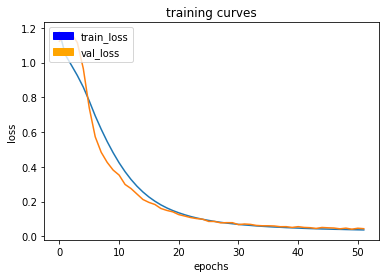

83/83 [==============================] - 109s - loss: 0.0374 - val_loss: 0.0444
Epoch 53/85
82/83 [============================>.] - ETA: 1s - loss: 0.0368

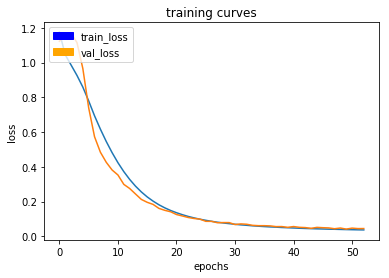

83/83 [==============================] - 110s - loss: 0.0368 - val_loss: 0.0447
Epoch 54/85
82/83 [============================>.] - ETA: 1s - loss: 0.0362

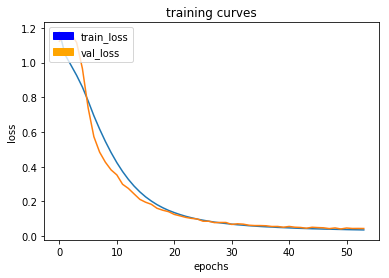

83/83 [==============================] - 110s - loss: 0.0361 - val_loss: 0.0443
Epoch 55/85
82/83 [============================>.] - ETA: 1s - loss: 0.0355

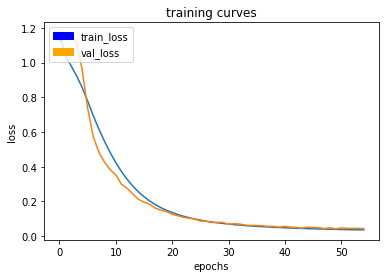

83/83 [==============================] - 110s - loss: 0.0355 - val_loss: 0.0431
Epoch 56/85
82/83 [============================>.] - ETA: 1s - loss: 0.0351

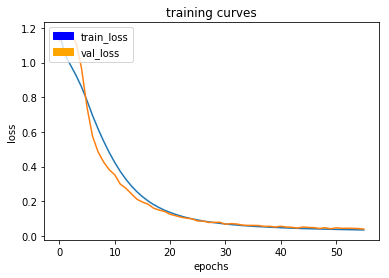

83/83 [==============================] - 110s - loss: 0.0351 - val_loss: 0.0398
Epoch 57/85
82/83 [============================>.] - ETA: 1s - loss: 0.0346

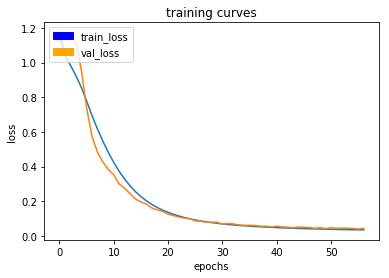

83/83 [==============================] - 109s - loss: 0.0345 - val_loss: 0.0439
Epoch 58/85
82/83 [============================>.] - ETA: 1s - loss: 0.0340

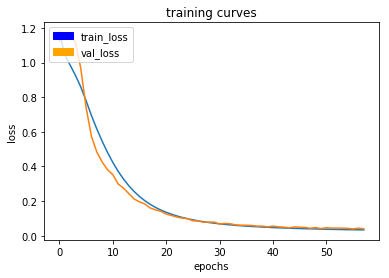

83/83 [==============================] - 110s - loss: 0.0340 - val_loss: 0.0408
Epoch 59/85
82/83 [============================>.] - ETA: 1s - loss: 0.0337

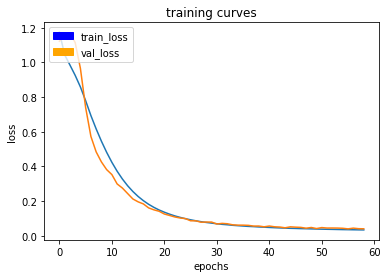

83/83 [==============================] - 110s - loss: 0.0337 - val_loss: 0.0402
Epoch 60/85
82/83 [============================>.] - ETA: 1s - loss: 0.0329

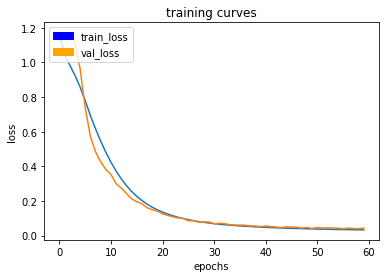

83/83 [==============================] - 110s - loss: 0.0330 - val_loss: 0.0434
Epoch 61/85
82/83 [============================>.] - ETA: 1s - loss: 0.0325

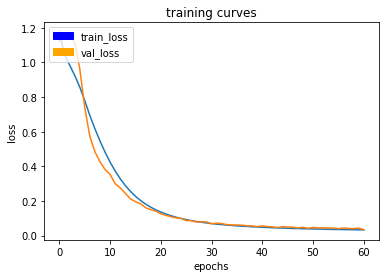

83/83 [==============================] - 109s - loss: 0.0325 - val_loss: 0.0339
Epoch 62/85
82/83 [============================>.] - ETA: 1s - loss: 0.0321

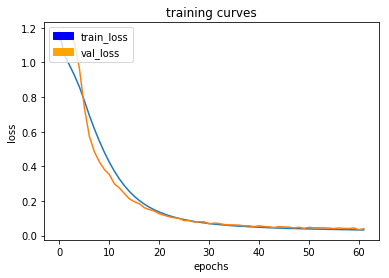

83/83 [==============================] - 109s - loss: 0.0323 - val_loss: 0.0394
Epoch 63/85
82/83 [============================>.] - ETA: 1s - loss: 0.0317

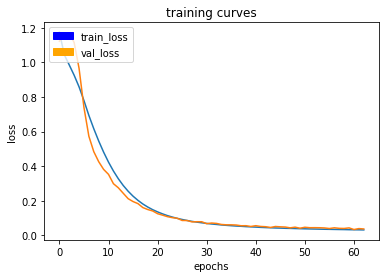

83/83 [==============================] - 110s - loss: 0.0317 - val_loss: 0.0372
Epoch 64/85
82/83 [============================>.] - ETA: 1s - loss: 0.0315

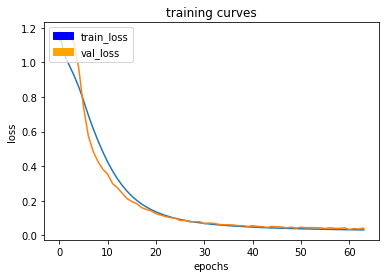

83/83 [==============================] - 110s - loss: 0.0315 - val_loss: 0.0418
Epoch 65/85
82/83 [============================>.] - ETA: 1s - loss: 0.0313

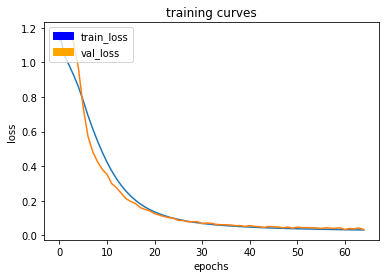

83/83 [==============================] - 109s - loss: 0.0313 - val_loss: 0.0340
Epoch 66/85
82/83 [============================>.] - ETA: 1s - loss: 0.0305

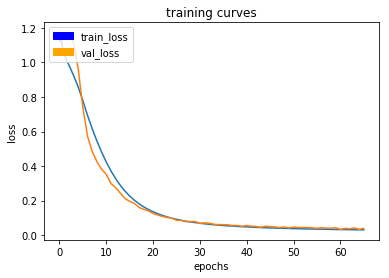

83/83 [==============================] - 110s - loss: 0.0305 - val_loss: 0.0395
Epoch 67/85
82/83 [============================>.] - ETA: 1s - loss: 0.0304

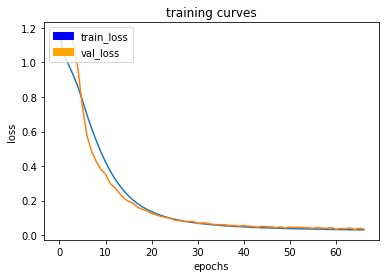

83/83 [==============================] - 109s - loss: 0.0304 - val_loss: 0.0359
Epoch 68/85
82/83 [============================>.] - ETA: 1s - loss: 0.0300

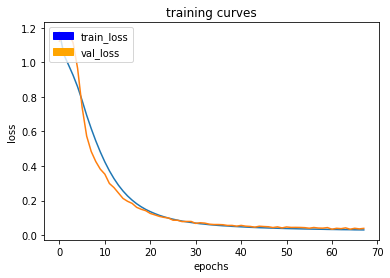

83/83 [==============================] - 109s - loss: 0.0300 - val_loss: 0.0389
Epoch 69/85
82/83 [============================>.] - ETA: 1s - loss: 0.0296

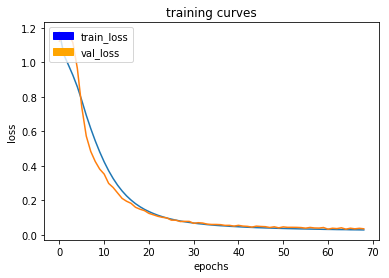

83/83 [==============================] - 109s - loss: 0.0296 - val_loss: 0.0362
Epoch 70/85
82/83 [============================>.] - ETA: 1s - loss: 0.0294

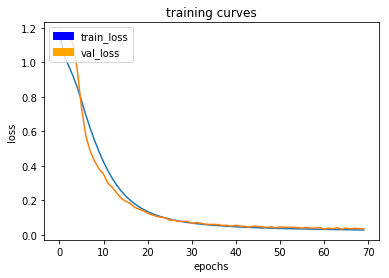

83/83 [==============================] - 108s - loss: 0.0294 - val_loss: 0.0361
Epoch 71/85
82/83 [============================>.] - ETA: 1s - loss: 0.0292

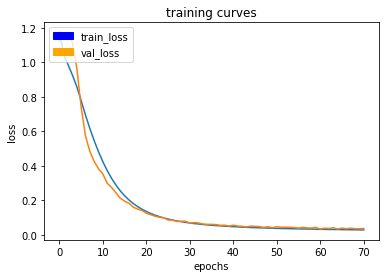

83/83 [==============================] - 108s - loss: 0.0291 - val_loss: 0.0372
Epoch 72/85
82/83 [============================>.] - ETA: 1s - loss: 0.0288

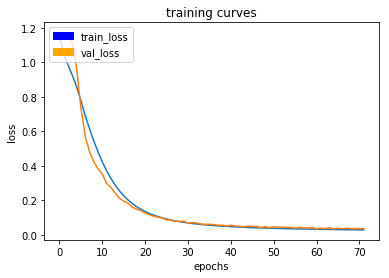

83/83 [==============================] - 109s - loss: 0.0288 - val_loss: 0.0355
Epoch 73/85
82/83 [============================>.] - ETA: 1s - loss: 0.0285

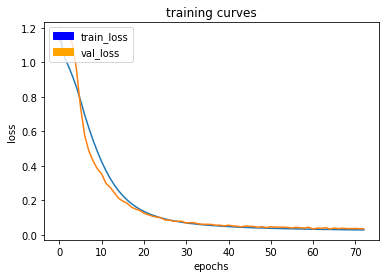

83/83 [==============================] - 108s - loss: 0.0286 - val_loss: 0.0351
Epoch 74/85
82/83 [============================>.] - ETA: 1s - loss: 0.0281

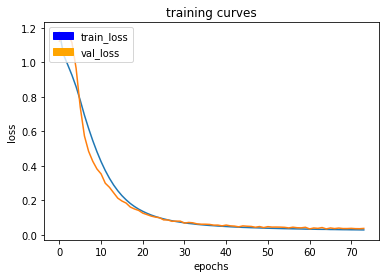

83/83 [==============================] - 108s - loss: 0.0281 - val_loss: 0.0368
Epoch 75/85
82/83 [============================>.] - ETA: 1s - loss: 0.0281

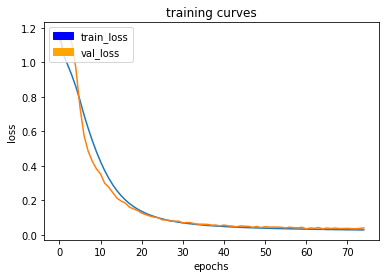

83/83 [==============================] - 109s - loss: 0.0281 - val_loss: 0.0398
Epoch 76/85
82/83 [============================>.] - ETA: 1s - loss: 0.0277

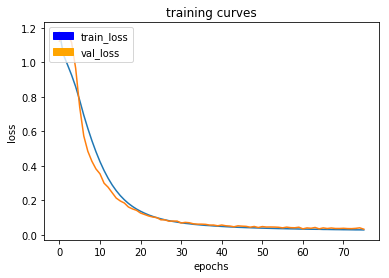

83/83 [==============================] - 110s - loss: 0.0277 - val_loss: 0.0320
Epoch 77/85
82/83 [============================>.] - ETA: 1s - loss: 0.0276

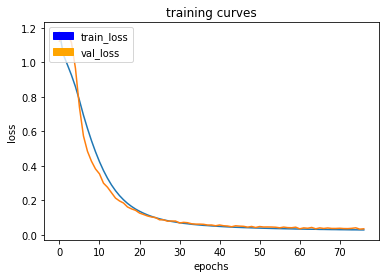

83/83 [==============================] - 109s - loss: 0.0275 - val_loss: 0.0342
Epoch 78/85
82/83 [============================>.] - ETA: 1s - loss: 0.0273

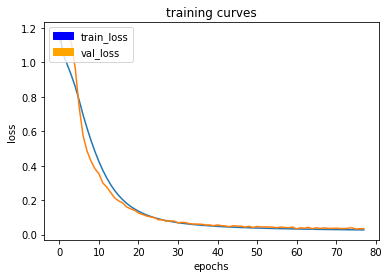

83/83 [==============================] - 110s - loss: 0.0272 - val_loss: 0.0349
Epoch 79/85
82/83 [============================>.] - ETA: 1s - loss: 0.0271

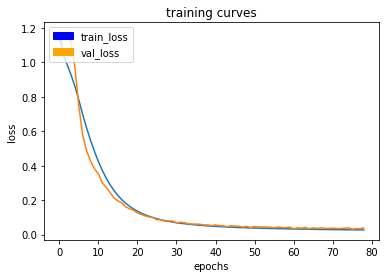

83/83 [==============================] - 109s - loss: 0.0272 - val_loss: 0.0387
Epoch 80/85
82/83 [============================>.] - ETA: 1s - loss: 0.0271

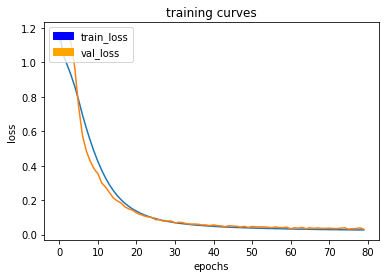

83/83 [==============================] - 110s - loss: 0.0271 - val_loss: 0.0314
Epoch 81/85
82/83 [============================>.] - ETA: 1s - loss: 0.0267

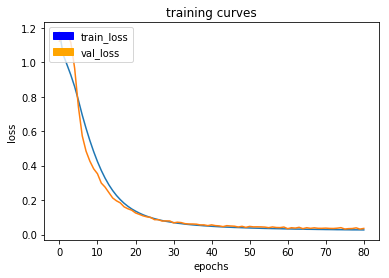

83/83 [==============================] - 109s - loss: 0.0267 - val_loss: 0.0354
Epoch 82/85
82/83 [============================>.] - ETA: 1s - loss: 0.0262

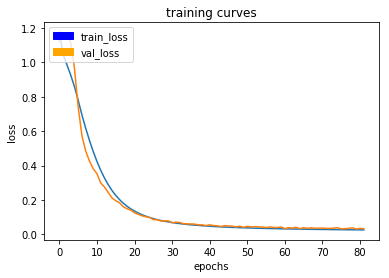

83/83 [==============================] - 110s - loss: 0.0266 - val_loss: 0.0336
Epoch 83/85
82/83 [============================>.] - ETA: 1s - loss: 0.0263

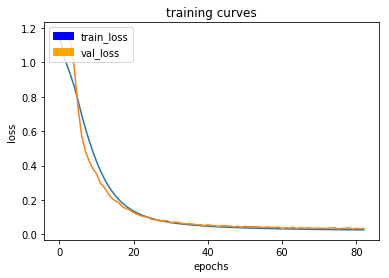

83/83 [==============================] - 109s - loss: 0.0263 - val_loss: 0.0339
Epoch 84/85
82/83 [============================>.] - ETA: 1s - loss: 0.0259

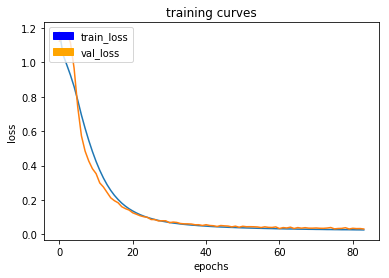

83/83 [==============================] - 110s - loss: 0.0259 - val_loss: 0.0313
Epoch 85/85
82/83 [============================>.] - ETA: 1s - loss: 0.0260

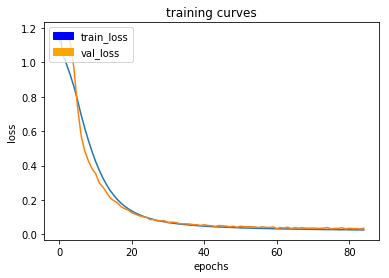

83/83 [==============================] - 109s - loss: 0.0259 - val_loss: 0.0357


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)
model.summary()

#keras.plot_model(model, to_file='model.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 20, 128)       512       
__________

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

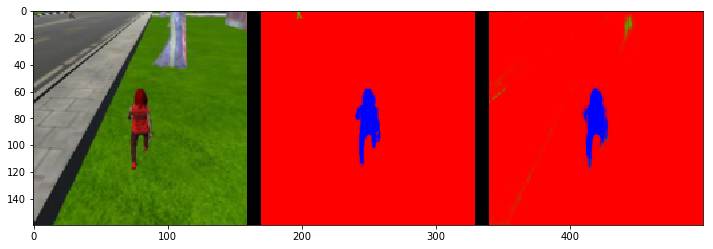

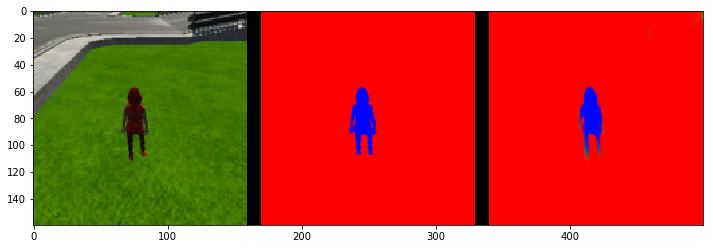

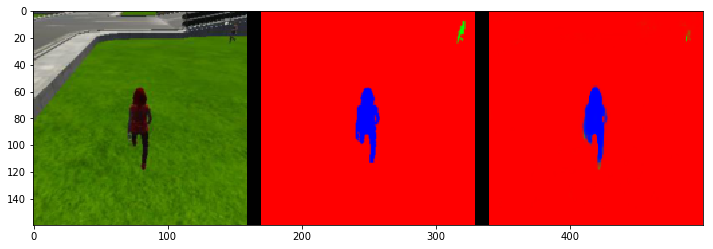

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

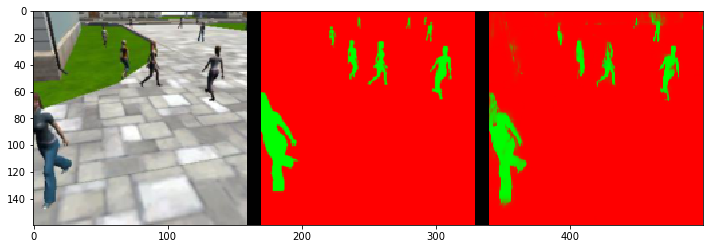

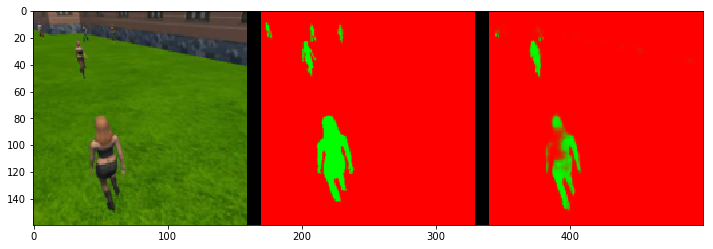

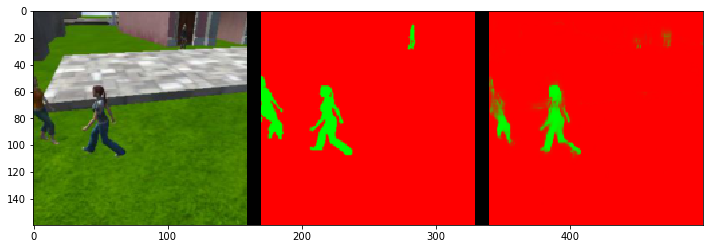

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

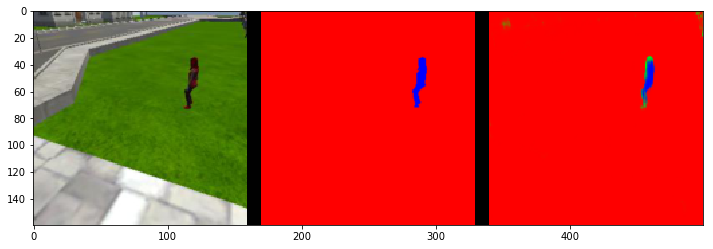

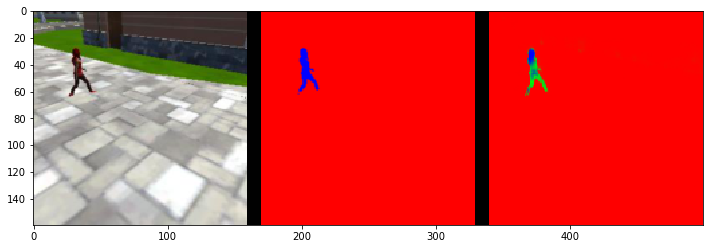

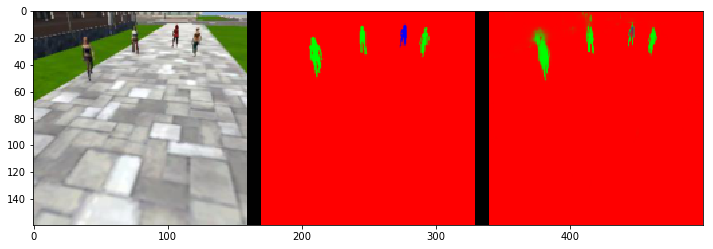

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9940878051375855
average intersection over union for other people is 0.2728995207006108
average intersection over union for the hero is 0.8507838881488023
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9793345586400819
average intersection over union for other people is 0.5735031310078857
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 60, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9951791993476701
average intersection over union for other people is 0.35117309346291087
average intersection over union for the hero is 0.09256102071535438
number true positives: 72, number false positives: 3, number false negatives: 229


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6766334440753046


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.471672454432


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.319149357318
